In [2]:
import torch 
from torch.utils import data
from torch import nn

from typing import List, Tuple, Dict, Union, Optional
from typing import Iterable

import pandas as pd
import numpy as np
import surprise

from sdv.tabular import CTGAN, GaussianCopula, CopulaGAN
import time

from tqdm.notebook import tqdm

In [3]:
import sys
import os 

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

sys.path.insert(0, r'./modules/')

In [4]:
from modules import AutoRec, Model, CollobarativeModel
from modules import get_validation_data, Dataset
from modules import nmf, svd, knn, autorec

In [3]:
SEED = 2022
MATRIX_SIZE = 3
USERS_COUNT = 250
ITEMS_COUNT = 100

SEED = 2022
REAL_DATASET_SAMPLE_SIZE = 0.05
CACHE_DIR = "./cache"
SYNTHETIC_USERS_COUNT = 250
SYNTHETIC_ITEMS_COUNT = 100
ALPHA_SAMPLE_RATE = 20
CNT = 25

SAMPLE_SIZE = [0.1, 0.5, 0.9]

In [4]:
to_dataset = lambda x: Dataset(x, 
                  validation_data.user_id.unique().shape[0], 
                  validation_data.item_id.unique().shape[0], 
                  user_based=True,
                  long_matrix=True,
                  user_column="user_id", item_column="item_id", rating_column="rating")

In [6]:
validation_data, heristic = get_validation_data()

## 1. Real validation data experiments

### 1.1. Dense case

In [7]:
result = pd.DataFrame()

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [ ]:
for sample in SAMPLE_SIZE:
    TRAIN, TEST = [], []
    for i in range(CNT):
        data_sparse = validation_data
        data_sparse = data_sparse.sample(frac=sample)
        data_train = data_sparse.sample(frac=0.8)
        data_test = data_sparse.drop(data_train.index)

        heu_train = heristic.loc[data_train.index]
        heu_test = heristic.loc[data_test.index]

        TRAIN.append(data_train)
        TEST.append(data_test)
        
    TRAIN = list(map(to_dataset, TRAIN))
    TEST = list(map(to_dataset, TEST))
    
    print("SVD")
    print("-------------------------------------")
    svd_result = svd(TRAIN, TEST, sample, cnt=CNT)
    print("NMF")
    print("-------------------------------------")
    nmf_result = nmf(TRAIN, TEST, sample, cnt=CNT)
    print("kNN")
    print("-------------------------------------")
    knn_result = knn(TRAIN, TEST, sample, cnt=CNT)
    print("AutoRec")
    print("-------------------------------------")
    autorec_result = autorec(TRAIN, TEST, validation_data, sample, cnt=CNT)
    
    result = result.append(svd_result)
    result = result.append(nmf_result)
    result = result.append(knn_result)
    result = result.append(autorec_result)

In [9]:
real_dense = result.copy()

### 1.2. Sparse case

In [10]:
result = pd.DataFrame()

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [ ]:
for sample in SAMPLE_SIZE:
    TRAIN, TEST = [], []
    for i in range(CNT):
        data_sparse = validation_data.sample(frac=REAL_DATASET_SAMPLE_SIZE)
        data_sparse = data_sparse.sample(frac=sample)
        data_train = data_sparse.sample(frac=0.8)
        data_test = data_sparse.drop(data_train.index)

        heu_train = heristic.loc[data_train.index]
        heu_test = heristic.loc[data_test.index]

        TRAIN.append(data_train)
        TEST.append(data_test)
        
    TRAIN = list(map(to_dataset, TRAIN))
    TEST = list(map(to_dataset, TEST))
    
    print("SVD")
    print("-------------------------------------")
    svd_result = svd(TRAIN, TEST, sample, cnt=CNT)
    print("NMF")
    print("-------------------------------------")
    nmf_result = nmf(TRAIN, TEST, sample, cnt=CNT)
    print("kNN")
    print("-------------------------------------")
    knn_result = knn(TRAIN, TEST, sample, cnt=CNT)
    print("AutoRec")
    print("-------------------------------------")
    autorec_result = autorec(TRAIN, TEST, validation_data, sample, cnt=CNT)
    
    result = result.append(svd_result)
    result = result.append(nmf_result)
    result = result.append(knn_result)
    result = result.append(autorec_result)

In [12]:
real_sparse = result.copy()

## 2. Synthetic validation data experiments

## 2.1. The Fitting of data generators

In [14]:
def fit_and_evaluate_models(df, models, sample_size, file_name, eval_kwargs):
    result = pd.DataFrame()
    for name, model in models.items():
        start = time.time()
        model.fit(df)
        model.save(os.path.join('../..', r'./data_generators/validation_data/' + str(name) + '_' + file_name + '.pkl'))
        end = time.time()
        print("Fitting of " + name)
        print(end - start)
        eval_result = evaluate(df, model.sample(sample_size), **eval_kwargs)
        eval_result["model_name"] = name
        eval_result["time"] = end-start
        result = pd.concat([result, eval_result])
        
    return result

In [15]:
users = validation_data.iloc[:, :4].drop_duplicates().reset_index(drop=True)
items = validation_data.iloc[:, 4:-1].drop_duplicates().reset_index(drop=True)

users_df = users.drop(['user_id'], axis = 1)
items_df = items.drop(['item_id'], axis = 1)

#### 2.1.1. Users data

In [16]:
from sdv.evaluation import evaluate

_comp_result = fit_and_evaluate_models(
    df=users_df,
    models={"GaussianCopula": GaussianCopula(), 
        "CTGAN": CTGAN(verbose=True), "CopulaGAN": CopulaGAN(verbose=True)},
    sample_size=1_000,
    file_name = 'users',
    eval_kwargs={"aggregate": False}
)

/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:4798: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:4789: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  wa

Fitting of GaussianCopula
0.8817873001098633


/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data[pd.isna(real_data)] = 0.0
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/pandas/core/frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Epoch 1, Loss G: -0.0277, Loss D:  0.0110
Epoch 2, Loss G: -0.0353, Loss D: -0.0410
Epoch 3, Loss G: -0.0233, Loss D: -0.0008
Epoch 4, Loss G: -0.0203, Loss D: -0.0030
Epoch 5, Loss G: -0.0291, Loss D: -0.0105
Epoch 6, Loss G: -0.0495, Loss D: -0.0249
Epoch 7, Loss G: -0.0191, Loss D: -0.0700
Epoch 8, Loss G: -0.0198, Loss D: -0.0159
Epoch 9, Loss G: -0.0364, Loss D: -0.0645
Epoch 10, Loss G: -0.0360, Loss D: -0.0605
Epoch 11, Loss G: -0.0239, Loss D: -0.0554
Epoch 12, Loss G: -0.0252, Loss D:  0.0048
Epoch 13, Loss G: -0.0446, Loss D: -0.0393
Epoch 14, Loss G: -0.0549, Loss D: -0.0822
Epoch 15, Loss G: -0.0802, Loss D:  0.0110
Epoch 16, Loss G: -0.1081, Loss D: -0.0659
Epoch 17, Loss G: -0.1573, Loss D: -0.0352
Epoch 18, Loss G: -0.1263, Loss D:  0.0639
Epoch 19, Loss G: -0.1571, Loss D: -0.0198
Epoch 20, Loss G: -0.1403, Loss D:  0.0014
Epoch 21, Loss G: -0.1973, Loss D:  0.0175
Epoch 22, Loss G: -0.1691, Loss D: -0.0050
Epoch 23, Loss G: -0.2141, Loss D:  0.0720
Epoch 24, Loss G: -0

/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data[pd.isna(real_data)] = 0.0
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/pandas/core/frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Epoch 1, Loss G:  0.0102, Loss D: -0.0178
Epoch 2, Loss G: -0.0093, Loss D: -0.0259
Epoch 3, Loss G:  0.0521, Loss D: -0.0030
Epoch 4, Loss G:  0.0281, Loss D: -0.0476
Epoch 5, Loss G:  0.0212, Loss D: -0.0123
Epoch 6, Loss G:  0.0123, Loss D: -0.0336
Epoch 7, Loss G:  0.0371, Loss D: -0.0040
Epoch 8, Loss G:  0.0005, Loss D: -0.0219
Epoch 9, Loss G:  0.0054, Loss D: -0.0087


/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Epoch 10, Loss G:  0.0212, Loss D: -0.0110
Epoch 11, Loss G:  0.0045, Loss D: -0.0012
Epoch 12, Loss G: -0.0257, Loss D: -0.0235
Epoch 13, Loss G: -0.0105, Loss D: -0.0156
Epoch 14, Loss G:  0.0129, Loss D: -0.0477
Epoch 15, Loss G: -0.0257, Loss D: -0.0078
Epoch 16, Loss G: -0.0497, Loss D:  0.0179
Epoch 17, Loss G: -0.0411, Loss D:  0.0755
Epoch 18, Loss G:  0.0022, Loss D:  0.0495
Epoch 19, Loss G: -0.0755, Loss D:  0.1000
Epoch 20, Loss G: -0.0232, Loss D:  0.0756
Epoch 21, Loss G: -0.0792, Loss D:  0.0494
Epoch 22, Loss G: -0.0299, Loss D: -0.0137
Epoch 23, Loss G:  0.0065, Loss D: -0.0014
Epoch 24, Loss G: -0.0325, Loss D: -0.0009
Epoch 25, Loss G: -0.0040, Loss D:  0.1171
Epoch 26, Loss G:  0.0463, Loss D:  0.1064
Epoch 27, Loss G: -0.0369, Loss D:  0.0209
Epoch 28, Loss G: -0.0085, Loss D:  0.0354
Epoch 29, Loss G:  0.0493, Loss D: -0.0420
Epoch 30, Loss G: -0.0143, Loss D:  0.0551
Epoch 31, Loss G:  0.0483, Loss D: -0.0094
Epoch 32, Loss G:  0.0412, Loss D: -0.1275
Epoch 33, L

/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data[pd.isna(real_data)] = 0.0
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/pandas/core/frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

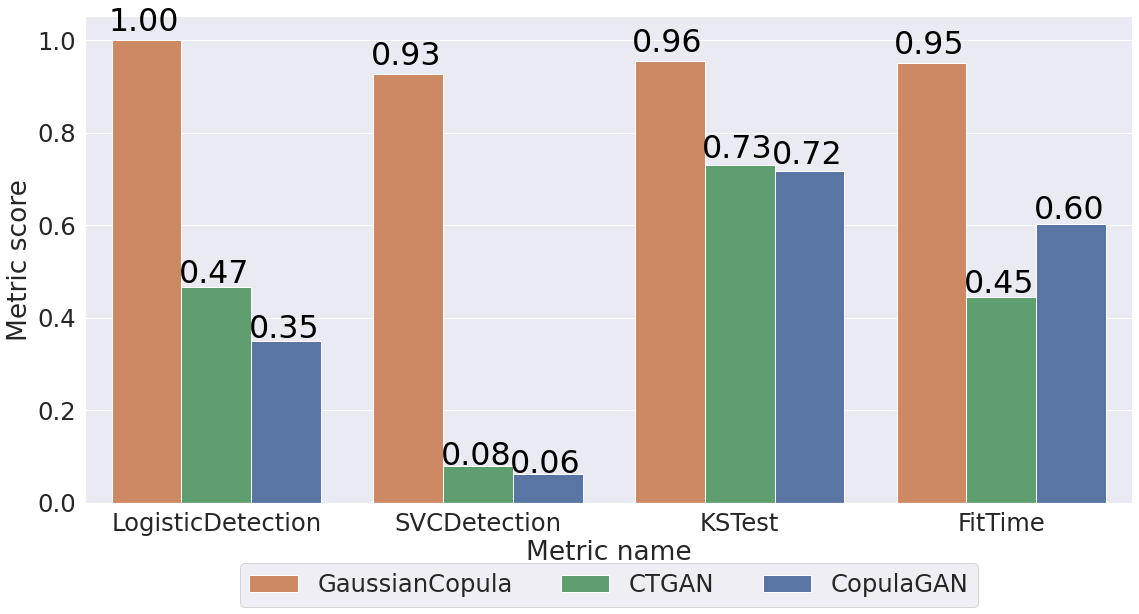

In [17]:
rs = _comp_result[
    (_comp_result.metric == "LogisticDetection") |
    (_comp_result.metric == "SVCDetection") |
    (_comp_result.metric == "KSTest") 
]

rs=rs.append(pd.DataFrame({'metric' : ['FitTime']*3, 
                        'raw_score' : [0.9518033195586475, 0.4455153260508047, 0.6026813543905478],
                        'model_name' : ['GaussianCopula', 'CTGAN', 'CopulaGAN']}))

import matplotlib
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
rs["Model name"] = rs["model_name"]
rs["Metric score"] = rs["raw_score"]
rs["Metric name"] = rs["metric"]
rcParams['figure.figsize'] = (3, 3)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
sns.set(font_scale=2.2)  # crazy big
plot = sns.catplot(data=rs, x="Metric name", y="Metric score", hue="Model name", kind="bar", aspect=2, height=8, palette=[
    "C1", "C2", "C0"
], legend=False)
ax = plot.facet_axis(0,0)
hist_values = [rs.iloc[0, 2], rs.iloc[1, 2], rs.iloc[2, 2], rs.iloc[9, 2],
               rs.iloc[3, 2], rs.iloc[4, 2], rs.iloc[5, 2], rs.iloc[10, 2],
               rs.iloc[6, 2], rs.iloc[7, 2], rs.iloc[8, 2], rs.iloc[11, 2]]
for (p, val) in zip(ax.patches, hist_values):
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{:1.2f}'.format(val),   #Used to format it K representation
            color='black', 
            rotation='horizontal', 
            size='large')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=3)

#### 2.1.2. Items data

In [18]:
_comp_result_ = fit_and_evaluate_models(
    df=items_df,
    models={"GaussianCopula": GaussianCopula(), 
        "CTGAN": CTGAN(verbose=True), "CopulaGAN": CopulaGAN(verbose=True)},
    sample_size=1_000,
    file_name = 'items',
    eval_kwargs={"aggregate": False}
)

/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:4798: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:4789: RuntimeWarning: divide by zero encountere

Fitting of GaussianCopula
0.6770632266998291


/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data[pd.isna(real_data)] = 0.0
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/pandas/core/frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Epoch 1, Loss G:  0.0336, Loss D:  0.0377
Epoch 2, Loss G:  0.0248, Loss D:  0.0120
Epoch 3, Loss G: -0.0365, Loss D:  0.0258
Epoch 4, Loss G: -0.0173, Loss D:  0.0018
Epoch 5, Loss G: -0.0072, Loss D:  0.0398
Epoch 6, Loss G: -0.0280, Loss D: -0.0239
Epoch 7, Loss G: -0.0392, Loss D:  0.0182
Epoch 8, Loss G: -0.0695, Loss D: -0.0337
Epoch 9, Loss G: -0.0264, Loss D:  0.0023
Epoch 10, Loss G: -0.0664, Loss D: -0.0169
Epoch 11, Loss G: -0.0441, Loss D: -0.0117
Epoch 12, Loss G: -0.0890, Loss D: -0.0242
Epoch 13, Loss G: -0.1080, Loss D: -0.0218
Epoch 14, Loss G: -0.0962, Loss D: -0.0480
Epoch 15, Loss G: -0.1616, Loss D: -0.0497
Epoch 16, Loss G: -0.1217, Loss D: -0.0820
Epoch 17, Loss G: -0.1842, Loss D: -0.0723
Epoch 18, Loss G: -0.2024, Loss D: -0.1496
Epoch 19, Loss G: -0.1760, Loss D: -0.0802
Epoch 20, Loss G: -0.1990, Loss D: -0.1261
Epoch 21, Loss G: -0.2455, Loss D: -0.1738
Epoch 22, Loss G: -0.2559, Loss D: -0.1972
Epoch 23, Loss G: -0.2436, Loss D: -0.1969
Epoch 24, Loss G: -0

/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data[pd.isna(real_data)] = 0.0
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/pandas/core/frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Epoch 1, Loss G:  0.0122, Loss D: -0.0100
Epoch 2, Loss G: -0.0117, Loss D: -0.0580


/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Epoch 3, Loss G:  0.0210, Loss D:  0.0008
Epoch 4, Loss G:  0.0022, Loss D: -0.0229
Epoch 5, Loss G: -0.0100, Loss D:  0.0132
Epoch 6, Loss G: -0.0159, Loss D:  0.0051
Epoch 7, Loss G: -0.0326, Loss D: -0.0164
Epoch 8, Loss G: -0.0607, Loss D: -0.0512
Epoch 9, Loss G: -0.0642, Loss D: -0.0338
Epoch 10, Loss G: -0.0692, Loss D: -0.0221
Epoch 11, Loss G: -0.1220, Loss D:  0.0033
Epoch 12, Loss G: -0.1167, Loss D:  0.0415
Epoch 13, Loss G: -0.1811, Loss D:  0.0364
Epoch 14, Loss G: -0.1643, Loss D:  0.1134
Epoch 15, Loss G: -0.1962, Loss D:  0.0255
Epoch 16, Loss G: -0.2781, Loss D:  0.1486
Epoch 17, Loss G: -0.2698, Loss D:  0.1656
Epoch 18, Loss G: -0.3356, Loss D:  0.1466
Epoch 19, Loss G: -0.3769, Loss D:  0.2213
Epoch 20, Loss G: -0.3797, Loss D:  0.2057
Epoch 21, Loss G: -0.3612, Loss D:  0.2405
Epoch 22, Loss G: -0.4638, Loss D:  0.2053
Epoch 23, Loss G: -0.4602, Loss D:  0.2264
Epoch 24, Loss G: -0.5033, Loss D:  0.3570
Epoch 25, Loss G: -0.5062, Loss D:  0.2385
Epoch 26, Loss G: 

/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data[pd.isna(real_data)] = 0.0
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/pandas/core/frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
/data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/sdmetrics/column_pairs/statistical/kl_divergence.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

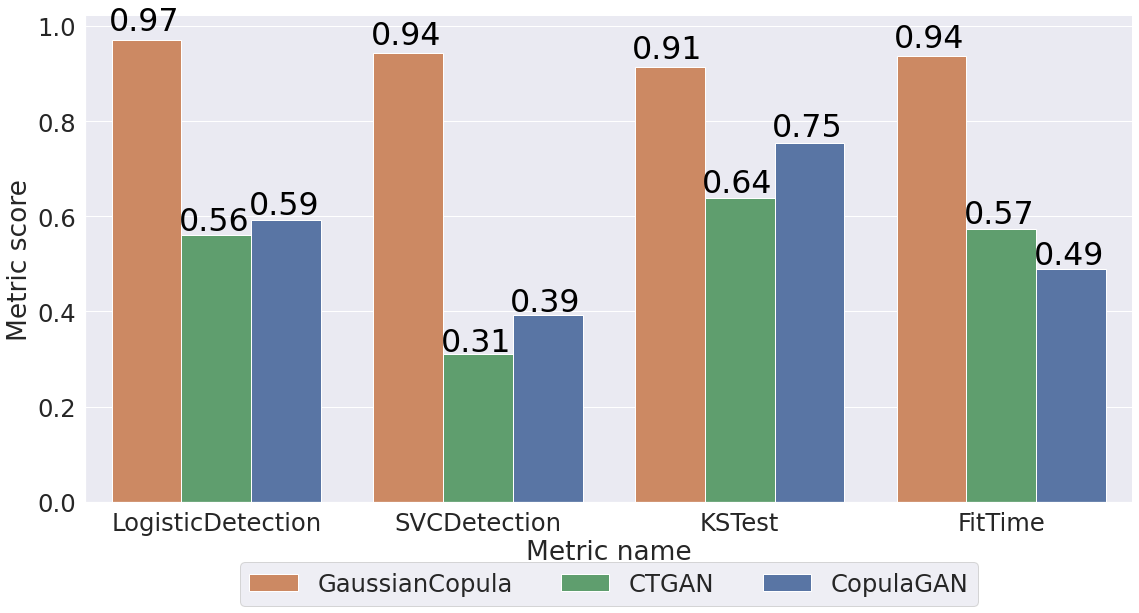

In [19]:
rs_ = _comp_result_[
    (_comp_result.metric == "LogisticDetection") |
    (_comp_result.metric == "SVCDetection") |
    (_comp_result.metric == "KSTest") 
]

rs_=rs_.append(pd.DataFrame({'metric' : ['FitTime']*3, 
                        'raw_score' : [0.9367300581907734, 0.5739131876661848, 0.4893567541430418],
                        'model_name' : ['GaussianCopula', 'CTGAN', 'CopulaGAN']}))


rs_["Model name"] = rs_["model_name"]
rs_["Metric score"] = rs_["raw_score"]
rs_["Metric name"] = rs_["metric"]
rcParams['figure.figsize'] = (3, 3)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
sns.set(font_scale=2.2)  # crazy big
plot = sns.catplot(data=rs_, x="Metric name", y="Metric score", hue="Model name", kind="bar", aspect=2, height=8, palette=[
    "C1", "C2", "C0"
], legend=False)
ax = plot.facet_axis(0,0)
hist_values = [rs_.iloc[0, 2], rs_.iloc[1, 2], rs_.iloc[2, 2], rs_.iloc[9, 2],
               rs_.iloc[3, 2], rs_.iloc[4, 2], rs_.iloc[5, 2], rs_.iloc[10, 2],
               rs_.iloc[6, 2], rs_.iloc[7, 2], rs_.iloc[8, 2], rs_.iloc[11, 2]]
for (p, val) in zip(ax.patches, hist_values):
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{:1.2f}'.format(val),   #Used to format it K representation
            color='black', 
            rotation='horizontal', 
            size='large')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=3)

In [19]:
syn_users_generator = GaussianCopula.load(os.path.join('../..', r'./data_generators/validation_data/GaussianCopula_users.pkl'))
syn_items_generator = CopulaGAN.load(os.path.join('../..', r'./data_generators/validation_data/GaussianCopula_items.pkl'))

### 2.2. DeepFM model

In [21]:
from deeptables.models.deeptable import DeepTable, ModelConfig
from deeptables.models import deepnets
from deeptables.datasets import dsutils
from tensorflow import keras
from deeptables.models import deeptable
from sklearn.model_selection import train_test_split

In [22]:
np.random.seed(SEED)
deepFM_X, deepFM_y = validation_data.drop(["user_id", "item_id", "rating"], axis=1), validation_data.rating.astype(int)
x_train, x_tests, y_train, y_test = train_test_split(deepFM_X, deepFM_y, test_size=0.2, random_state=42)

In [23]:
test_results = []
net = deepnets.DeepFM
conf = ModelConfig(
    nets=net, 
    metrics=['accuracy'], 
    optimizer=keras.optimizers.RMSprop(),
    auto_discrete=True,
    earlystopping_patience=10,
    home_dir = r'../models/',
    dnn_params={
        'dnn_activation': 'relu',
    },
)

In [24]:
dt = deeptable.DeepTable(config=conf)
start = time.time()
model, history = dt.fit(x_train, y_train, epochs=100, batch_size=64)
end = time.time()
print('Training of DeepFM')
print(end - start)

09-22 09:50:44 I deeptables.m.deeptable.py 335 - X.Shape=(20000, 6), y.Shape=(20000,), batch_size=64, config=ModelConfig(name='conf-1', nets=['dnn_nets', 'fm_nets', 'linear'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['accuracy'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=4, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=False, optimizer=<tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x7f42941de0b8>, loss='auto', dnn_params={'dnn_activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True}, 

In [26]:
score = dt.evaluate(deepFM_X, deepFM_y, batch_size=64, verbose=0)
score

09-22 09:52:44 I deeptables.m.preprocessor.py 239 - Transform [X]...
09-22 09:52:44 I deeptables.m.preprocessor.py 246 - transform_X taken 0.022706031799316406s
09-22 09:52:44 I deeptables.m.preprocessor.py 227 - Transform [y]...
09-22 09:52:44 I deeptables.m.preprocessor.py 233 - transform_y taken 0.0014374256134033203s
09-22 09:52:44 I deeptables.m.deepmodel.py 169 - Performing evaluation...


{'loss': 1.2165235907745362, 'accuracy': 0.57348}

### 2.3. Synthetic data generation

In [28]:
for idx in range(CNT):
    syn_users_df = syn_users_generator.sample(SYNTHETIC_USERS_COUNT)
    syn_items_df = syn_items_generator.sample(SYNTHETIC_ITEMS_COUNT)

    syn_users_df["user_id"] = range(len(syn_users_df))
    syn_items_df["item_id"] = range(len(syn_items_df))
    
    syn_users_df["_merge_key"] = syn_items_df["_merge_key"] = 1
    syn_merged_df = pd.merge(syn_users_df, syn_items_df, on="_merge_key")
    syn_merged_df = syn_merged_df.drop(["_merge_key"], axis=1)
    
    syn_users_matrix = np.asarray(syn_merged_df.drop(['user_id', 'item_id'], axis = 1).iloc[:, 0:MATRIX_SIZE])
    syn_items_matrix = np.asarray(syn_merged_df.drop(['user_id', 'item_id'], axis = 1).iloc[:, MATRIX_SIZE:])
    
    
    df_resp = syn_merged_df.copy()
    
    np.random.seed(SEED)
    resp = dt.predict(df_resp.drop(["user_id", "item_id"], axis=1))
    df_resp['rating'] = resp
    
    matrix = pd.DataFrame()
    matrix["rating"] = df_resp['rating']
    matrix["user_id"] = df_resp["user_id"].astype("category").cat.codes
    matrix["item_id"] = df_resp["item_id"].astype("category").cat.codes
    
    users_matrix = np.asarray(df_resp.drop(['user_id', 'item_id', 'rating'], axis = 1).iloc[:, 0:3] )
    items_matrix = np.asarray(df_resp.drop(['user_id', 'item_id', 'rating'], axis = 1).iloc[:, 3:])

    #calculation product and scalar product of vectors
    product = users_matrix * items_matrix
    scal_product = []
    for i in product:
        scal_product.append(np.sum(i))
    scal_product = np.asarray(scal_product)

    #calculation of vectors length
    user_len = []
    for i in users_matrix:
        user_len.append(np.sqrt(np.sum(i * i)))
    user_len = np.asarray(user_len)

    item_len = []
    for i in items_matrix:
        item_len.append(np.sqrt(np.sum(i * i)))
    item_len = np.asarray(item_len)

    #normalazed cos sim of vectors as response
    cos_sim_norm = 1 - np.arccos(scal_product/(user_len * item_len))/np.pi

    mink_distance = []
    for i in (users_matrix - items_matrix)**3:
        mink_distance.append(np.sum(i))

    mink_distance = np.sign(mink_distance) * np.power(np.abs(mink_distance), 1/3)
    mink_distance = (mink_distance - mink_distance.min()) / (mink_distance.max() - mink_distance.min())
    mink_distance = np.round(mink_distance * 10) % 10 + 1
    real_heu = pd.DataFrame({'user_id' : df_resp.user_id, 'item_id' : df_resp.item_id, 'rating' : mink_distance})
    
    matrix.to_csv(os.path.join('../..', r"./synthetic_data/validation_data/dense_"+str(idx)+'.csv'), index=False)
    real_heu.to_csv(os.path.join('../..', r"./synthetic_data/validation_data/dense_hue_"+str(idx)+'.csv'), index=False)

09-22 09:54:24 I deeptables.m.deeptable.py 661 - Perform prediction...
09-22 09:54:24 I deeptables.m.preprocessor.py 239 - Transform [X]...
09-22 09:54:24 I deeptables.m.preprocessor.py 246 - transform_X taken 0.022220373153686523s
09-22 09:54:24 I deeptables.m.deepmodel.py 142 - Performing predictions...
09-22 09:54:24 I deeptables.m.deeptable.py 540 - predict_proba taken 0.2908468246459961s
09-22 09:54:24 I deeptables.m.deeptable.py 575 - Reverse indicators to labels.
09-22 09:54:25 I deeptables.m.deeptable.py 661 - Perform prediction...
09-22 09:54:25 I deeptables.m.preprocessor.py 239 - Transform [X]...
09-22 09:54:25 I deeptables.m.preprocessor.py 246 - transform_X taken 0.01909184455871582s
09-22 09:54:25 I deeptables.m.deepmodel.py 142 - Performing predictions...
09-22 09:54:25 I deeptables.m.deeptable.py 540 - predict_proba taken 0.3002634048461914s
09-22 09:54:25 I deeptables.m.deeptable.py 575 - Reverse indicators to labels.
09-22 09:54:26 I deeptables.m.deeptable.py 661 - Pe

### 2.4. Dense case

In [29]:
result = pd.DataFrame()

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [ ]:
for sample in SAMPLE_SIZE:
    TRAIN, TEST = [], []
    for i in range(CNT):
        data_sparse = pd.read_csv(os.path.join('../..', r"./synthetic_data/validation_data/dense_"+str(idx)+'.csv'))
        data_sparse = data_sparse.sample(frac=sample)
        data_train = data_sparse.sample(frac=0.8)
        data_test = data_sparse.drop(data_train.index)

        heu_train = heristic.loc[data_train.index]
        heu_test = heristic.loc[data_test.index]

        TRAIN.append(data_train)
        TEST.append(data_test)
        
    TRAIN = list(map(to_dataset, TRAIN))
    TEST = list(map(to_dataset, TEST))
    
    print("SVD")
    print("-------------------------------------")
    svd_result = svd(TRAIN, TEST, sample, cnt=CNT)
    print("NMF")
    print("-------------------------------------")
    nmf_result = nmf(TRAIN, TEST, sample, cnt=CNT)
    print("kNN")
    print("-------------------------------------")
    knn_result = knn(TRAIN, TEST, sample, cnt=CNT)
    print("AutoRec")
    print("-------------------------------------")
    autorec_result = autorec(TRAIN, TEST, validation_data, sample, cnt=CNT)
    
    result = result.append(svd_result)
    result = result.append(nmf_result)
    result = result.append(knn_result)
    result = result.append(autorec_result)

In [31]:
syn_dense = result.copy()

### 2.4. Sparse case

In [33]:
result = pd.DataFrame()

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [ ]:
for sample in SAMPLE_SIZE:
    TRAIN, TEST = [], []
    for i in range(CNT):
        data_sparse = pd.read_csv(os.path.join('../..', r"./synthetic_data/validation_data/dense_"+str(idx)+'.csv')).sample(frac=REAL_DATASET_SAMPLE_SIZE)
        data_sparse = data_sparse.sample(frac=sample)
        data_train = data_sparse.sample(frac=0.8)
        data_test = data_sparse.drop(data_train.index)

        heu_train = heristic.loc[data_train.index]
        heu_test = heristic.loc[data_test.index]

        TRAIN.append(data_train)
        TEST.append(data_test)
        
    TRAIN = list(map(to_dataset, TRAIN))
    TEST = list(map(to_dataset, TEST))
    
    print("SVD")
    print("-------------------------------------")
    svd_result = svd(TRAIN, TEST, sample, cnt=CNT, with_null=False)
    print("NMF")
    print("-------------------------------------")
    nmf_result = nmf(TRAIN, TEST, sample, cnt=CNT, with_null=False)
    print("kNN")
    print("-------------------------------------")
    knn_result = knn(TRAIN, TEST, sample, cnt=CNT, with_null=False)
    print("AutoRec")
    print("-------------------------------------")
    autorec_result = autorec(TRAIN, TRAIN, validation_data, sample, cnt=CNT)
    
    result = result.append(svd_result)
    result = result.append(nmf_result)
    result = result.append(knn_result)
    result = result.append(autorec_result)

In [35]:
syn_sparse = result.copy()

### 3. Results

In [5]:
from modules import boxplot
names = {'SVD': 'svd', 'AutoRec': 'autorec', 'NMF': 'nmf', 'kNN': 'knn'}

In [ ]:
real_dense = real_dense.model_name.apply(lambda x: names[x])
syn_dense = syn_dense.apply(lambda x: names[x])                                                              

In [21]:
names = {'SVD': 'svd', 'AutoRec': 'autorec', 'NMF': 'nmf', 'kNN': 'knn'}
syn_dense = pd.read_csv(r"C:\Users\79697\Desktop\SinEvaRec\ndcg_results\NEW_validation_dense_syn.csv").rename(columns={'model': 'model_name'})
real_dense = pd.read_csv(r"C:\Users\79697\Desktop\SinEvaRec\ndcg_results\NEW_validation_dense_real.csv").rename(columns={'model': 'model_name'})
                                                              
syn_dense.model_name = syn_dense.model_name.apply(lambda x: names[x])
real_dense.model_name = real_dense.model_name.apply(lambda x: names[x])    

syn, real = syn_dense, real_dense


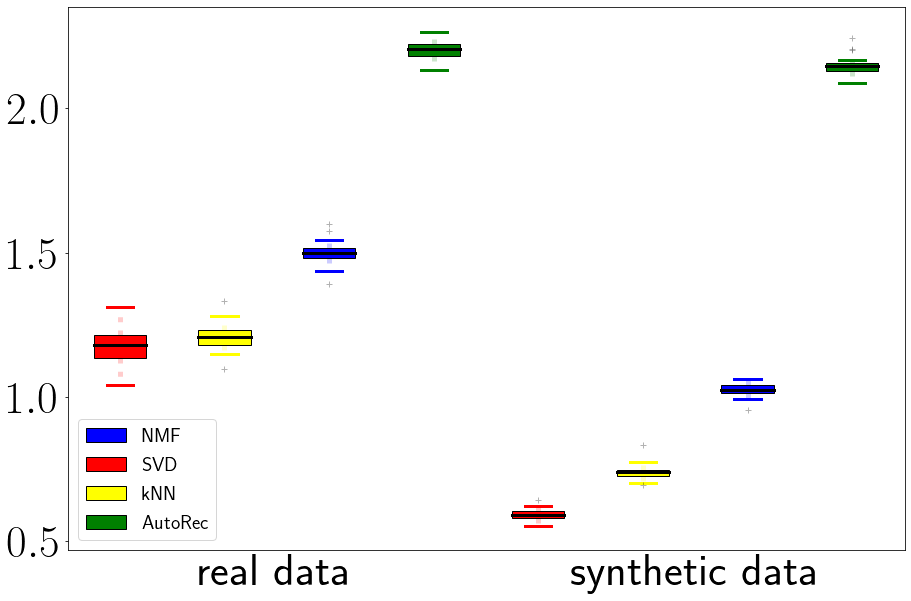

In [22]:
boxplot(real_dense[real_dense.sample_size == 0.5], syn_dense[syn_dense.sample_size == 0.5], column='rmse', legend_loc='lower left')

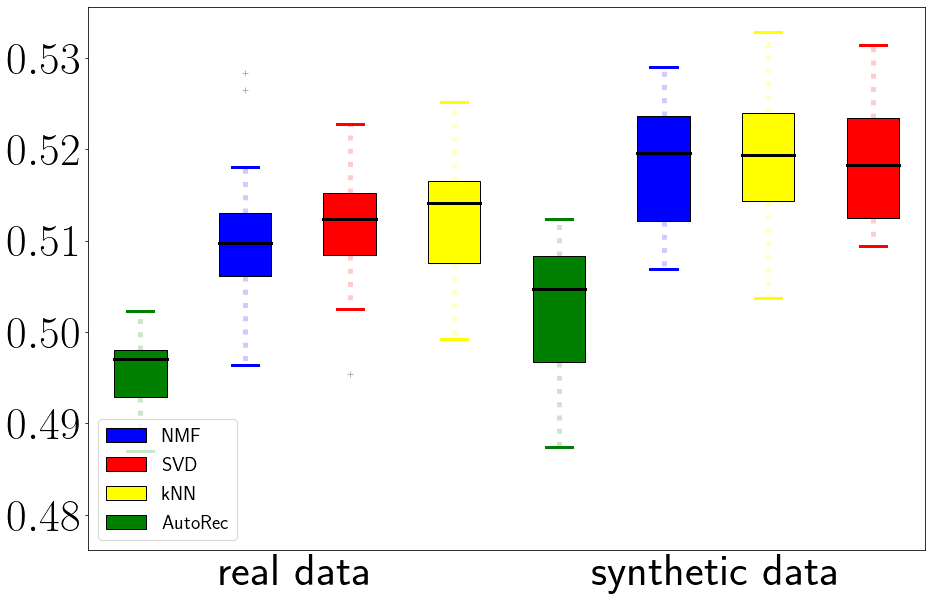

In [30]:
boxplot(real_dense[real_dense.sample_size == 0.5], syn_dense[syn_dense.sample_size == 0.5], column='ndcg', legend_loc='lower left')